### Data fields

<ul>
    <li>e Ownership - домовладение</li>
    <li>Annual Income - годовой доход</li>
    <li>Years in current job - количество лет на текущем месте работы</li>
    <li>Tax Liens - налоговые обременения<</li>
    <li>Number of Open Accounts - количество открытых счетов</li>
    <li>Years of Credit History - количество лет кредитной истории</li>
    <li>Maximum Open Credit - наибольший открытый кредит</li>
    <li>Number of Credit Problems - количество проблем с кредитом</li>
    <li>Months since last delinquent - количество месяцев с последней просрочки платежа</li>
    <li>Bankruptcies - банкротства</li>
    <li>Purpose - цель кредита</li>
    <li>Term - срок кредита</li>
    <li>Current Loan Amount - текущая сумма кредита</li>
    <li>Current Credit Balance - текущий кредитный баланс</li>
    <li>Monthly Debt - ежемесячный долг</li>
    <li>Credit Score - баллы кредитного рейтинга</li>
    <li>Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)</li>
</ul>

In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor


%matplotlib inline

In [44]:
df = pd.read_csv('data/course_project/train.csv')


X = df.drop('Credit Default', axis=1)
y = df[['Credit Default']]


X_final = pd.read_csv('data/course_project/test.csv')


print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 7500
Строк в тесте 2500


105

In [5]:
X.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [42]:
X['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

(array([ 7.,  0., 12., 16., 11.,  6., 16.,  8., 11.,  2.]),
 array([ 1. ,  8.5, 16. , 23.5, 31. , 38.5, 46. , 53.5, 61. , 68.5, 76. ]),
 <BarContainer object of 10 artists>)

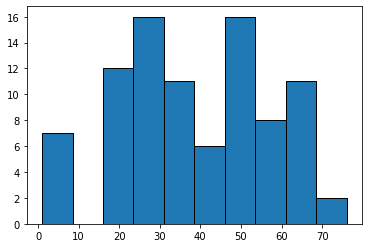

In [39]:
plt.hist(X['Months since last delinquent'].value_counts(), bins=10,edgecolor='black')

In [43]:
y.head(10)

,Credit Default
0,0
1,1
2,0
3,0
4,0
5,1
6,0
7,1
8,0
9,1


In [45]:
X['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [49]:
X['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64